In [43]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import postprocess as pp
import os

from irrevolutions.utils import eigenspace as eig

In [72]:
import os
import yaml
import matplotlib.pyplot as plt
from irrevolutions.utils.eigenspace import l2_norm

def load_parameters(directory):
    parameters_file = os.path.join(directory, 'parameters.yaml')
    if os.path.exists(parameters_file):
        with open(parameters_file, 'r') as f:
            parameters = yaml.safe_load(f)
        return parameters
    else:
        return None
    
def load_signature(directory):
    signature_file = os.path.join(directory, 'signature.md5')
    if os.path.exists(signature_file):
        with open(signature_file, 'r') as f:
            signature = yaml.safe_load(f)
        return signature
    else:
        return None
    
def compute_contour(a_values, bc_square_values):
    a, bcsq = np.meshgrid(a_values, bc_square_values)
    D_values = (np.pi**2 * a / bcsq)**(1/3)
    return a, bcsq, D_values

def plot_phase_space(rootdir):
    successful_points = []
    unsuccessful_points = []
    points_count = {}

    for subdir, _, _ in os.walk(rootdir):
        parameters = load_parameters(subdir)
        if parameters is not None:
            a = parameters.get('model', {}).get('a')
            b = parameters.get('model', {}).get('b')
            c = parameters.get('model', {}).get('c')

            # Check if the computation is successful based on the existence of mode_shapes_data.npz
            success_file = os.path.join(subdir, 'mode_shapes_data.npz')
            datapoint = (np.pi**2 * a, b*c**2)
            
            if os.path.exists(success_file):
                successful_points.append(datapoint)
            else:
                unsuccessful_points.append(datapoint)

            points_count[datapoint] = points_count.get(datapoint, 0) + 1

    for datapoint, count in points_count.items():
        # plt.scatter(*datapoint, label=f'Multiplicity: {count}', marker='')
        # plt.scatter(*datapoint, marker='')
        plt.annotate(f'\#{count}', datapoint, textcoords="offset points", xytext=(0, -15), ha='center')

    # Create the plot
    plt.scatter(*zip(*unsuccessful_points), label='Unsuccessful', marker='x')
    plt.scatter(*zip(*successful_points), label='Successful', marker='.', s=200)
    plt.xlabel('$\pi^2 a$')
    plt.ylabel('$bc^2$')
    plt.legend()
    a_values = np.linspace(0, 100, 100)
    bc_sq_values = np.linspace(0, 100, 100)
    a, bc_sq, D_values = compute_contour(a_values, bc_sq_values)
    plt.contour(bc_sq, a , D_values, levels=5, colors='black', linestyles='dashed')

    plt.show()

def plot_profile_comparison(parameters, mode, idx=[1, 1], reverse = False, signature=None):

    _fig, _axes = pp.plot_fields_for_time_step(mode)
    _axes[0].set_title('Eigenvectors (bifurcation problem)')
    _axes[1].set_title('Eigenvectors (stability problem)')
    _parameters = f'a = {parameters.get("a"):.2f}, b = {parameters.get("b"):.2f}, c = {parameters.get("c"):.2f}'
    _fig.suptitle(f"Rayleigh eigenproblem with parameters {_parameters}, signature {signature[0:6] if signature is not None else ''}")

    coeff_v = l2_norm([
        (mode['mesh'], mode['fields']['bifurcation_v']),
        (mode['mesh'], mode['fields']['bifurcation_β'])
        ])

    coeff_k = l2_norm([
        (mode['mesh'], mode['fields']['stability_β'])
        ])

    eigenspace_v, _normalisation_v = eig.solve_eigenspace_vector(parameters, idx=idx[0])
    eigenspace_k, _normalisation_k = eig.solve_eigenspace_cone(parameters, idx=idx[1])

    v, β = eigenspace_v["v"], eigenspace_v["β"]

    x_values = np.linspace(0, 1, 100)
    v_function = sp.lambdify('x', v)
    β_function = sp.lambdify('x', β)

    v_values = [v_function(x) for x in x_values]
    β_values = [β_function(x) for x in x_values]

    _axes[0].plot(x_values, np.array(β_values)*coeff_v, label=r'$\beta(x)$', c='k')
    _axes[0].plot(x_values, np.array(v_values)*coeff_v, label=r'$v(x)$', c='k', linestyle='--')

    _axes[0].legend()
    
    v, β = eigenspace_k["v"], eigenspace_k["β"]
    D = eigenspace_k["D"]
    x_values = np.linspace(0, 1, 100)
    v_function = sp.lambdify('x', v)
    β_function = sp.lambdify('x', β)
    v_values = [v_function(x) for x in x_values]
    if reverse:
        β_values = [β_function(1-x) for x in x_values]
    else:
        β_values = [β_function(x) for x in x_values]

    _axes[1].plot(x_values, np.array(β_values)*coeff_k, label=r'$\beta(x)$', c='k')
    _axes[1].set_xticks([0, float(sp.N(D))], [0, "$D$"])
    _axes[1].legend()

    return _fig, _axes

def solve_eigenspace_vector(parameters, idx = 0):
    """
    Solve for the eigenspace in a vector space.

    Parameters:
        parameters (dict): A dictionary containing the values for 'a', 'b', and 'c'.
        idx (int): Index to choose the appropriate solution in case of multiple solutions.

    Returns:
        dict: A dictionary containing 'v', 'β', and 'D'.
    """
    x = sp.symbols('x', real=True)
    v = sp.Function('v', real=True)(x)
    β = sp.Function('β', real=True)(x)
    C, A = sp.symbols('C A')
    
    a = parameters["a"]
    b = parameters["b"]
    c = parameters["c"]    
    
    if b * c**2 < sp.pi**2 * a:
        print('case 1')
        _subs = {A: 0}
        A = 0
    elif b * c**2 > sp.pi**2 * a:
        print('case 2')
        _subs = {C: 0}
        C = 0
    
    
    β = C + A*sp.cos(sp.pi * x)
    v = c * A / sp.pi * sp.sin(sp.pi * x)

    depends_on_A = np.any([sp.symbols('A') in expression.free_symbols for expression in [v, β]])
    depends_on_C = np.any([sp.symbols('C') in expression.free_symbols for expression in [v, β]])
    
    _norm = sp.sqrt(np.sum([sp.integrate(eigenfunction**2, (x, 0, 1)) for eigenfunction in (v, β)]))

    print([expression.free_symbols for expression in [v, β]])
    print(_norm, depends_on_A, depends_on_C)
    
    if depends_on_A:
        print('depends_on_A')
        _normalise = [{sp.symbols('A'): ay} for ay in sp.solve(_norm - 1, A)]
    elif depends_on_C:
        print('depends_on_C')
        _normalise = [{sp.symbols('C'): cy} for cy in sp.solve(_norm - 1, C)]
        
    return {"v": v.subs(_normalise[idx]), "β": β.subs(_normalise[idx]), "D": 0}, _normalise[idx]







  plt.annotate(f'\#{count}', datapoint, textcoords="offset points", xytext=(0, -15), ha='center')

  plt.xlabel('$\pi^2 a$')



### To reproduce the paper's figures
1. run test_rayleigh.py
2. check the output


## Rayleigh benchmark

In [45]:
!ls ../../test/output/rayleigh-benchmark/MPI-1/

fd270a2cea62d7b0546f0d9f12189e39


In [46]:
experiment = '../../test/output/rayleigh-benchmark/MPI-1/fd270a2cea62d7b0546f0d9f12189e39'

params, data, signature = pp.load_data(experiment)


File 'time_data.json' not found. Handle this case accordingly.


In [47]:
modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)


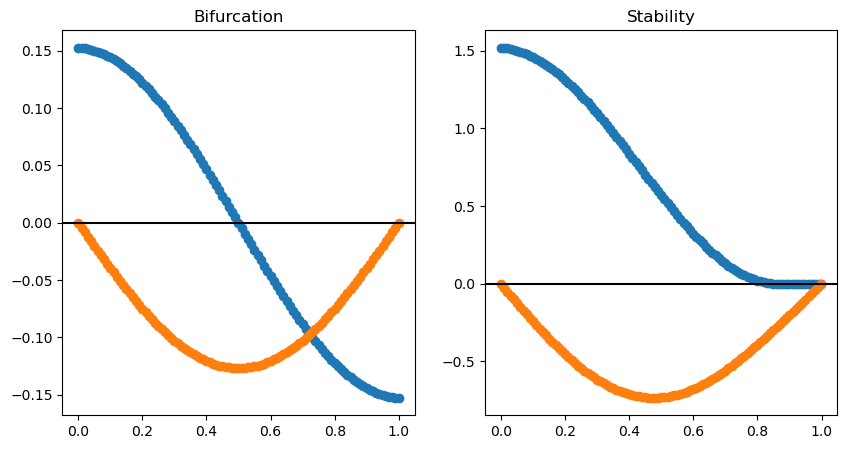

In [54]:
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)
_fig, _axes = pp.plot_fields_for_time_step(mode)


File 'time_data.json' not found. Handle this case accordingly.
case 2
[{A, x}, {A, x}]
sqrt(2*A**2/pi**2 + A**2/2) True False
depends_on_A
case 2
sqrt(0.227140074104017*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.227140074104017*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.90856029641607*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.227140074104017*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.454280148208035*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Eigenvectors (bifurcation problem)'}>,
        <Axes: title={'center': 'Eigenvectors (stability problem)'}>],
       dtype=object))

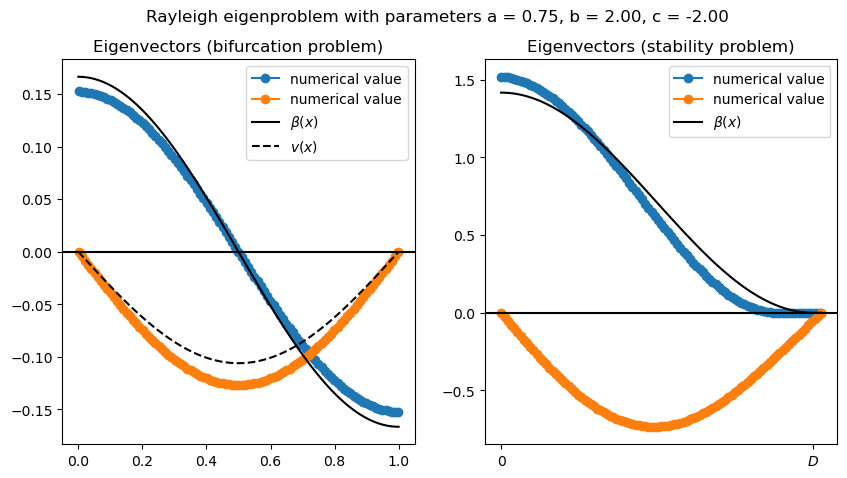

In [50]:
modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)

params, data, signature = pp.load_data(experiment)

a = params['model']['a']
b = params['model']['b']
c = params['model']['c']

parameters = {"a": a, "b": b, "c": c}

plot_profile_comparison(parameters, mode, idx=[1, 0], reverse=False)

## Parametric Rayleigh benchmark

1. run test_rayleigh_parametric.py
2. check the output folder

In [51]:
import os
cwd = os.getcwd()
path_components = cwd.split(os.path.sep)
path_components = path_components[0:-2]
dirroot =  '/' + os.path.join(*path_components, 'test', 'output', 'rayleigh-benchmark-parametric', 'MPI-1')

!ls $dirroot


06808bac7882952b9370be6b2039164e 5c7ca577865c83a225bac7413e984243
2be9e4cfecb92dd64399235ecd6cda75 6f75e27fd2217e6ae3302506d471f903
3c05ab9a5a759a3adb73c98280aa0706 761d2f24d28b7be2b7be8e3c9283a3cc
4008f7309718b6c041d67e1df419da16 7fc954e6a16c9db01466a73d4ff4863e
46e496acc5cc6b84744165e5de0a837f cd51ebe88c87def741f0826374e1c256
5796fd374d76ec67e0b456dcfb26436d f181dd1f8b8b21a1c9b9f19461c9829f


In [52]:
for subdir, dirs, files in os.walk(dirroot):
    if not os.path.isfile(subdir + "/signature.md5"):
        continue
    print(subdir)
    modes_data = np.load(os.path.join(subdir, 'mode_shapes_data.npz'), allow_pickle=True)
    mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=-1)
    params, data, signature = pp.load_data(subdir)



/Users/kumiori3/Documents/WIP/Nature/irrevolutions/test/output/rayleigh-benchmark-parametric/MPI-1/3c05ab9a5a759a3adb73c98280aa0706


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kumiori3/Documents/WIP/Nature/irrevolutions/test/output/rayleigh-benchmark-parametric/MPI-1/3c05ab9a5a759a3adb73c98280aa0706/mode_shapes_data.npz'

## From the book of the numbers...

In [55]:
eigenspace_v, _normalisation_v = eig.solve_eigenspace_vector(parameters)
eigenspace_k, _normalisation_k = eig.solve_eigenspace_cone(parameters)


case 2
[{A, x}, {A, x}]
sqrt(2*A**2/pi**2 + A**2/2) True False
depends_on_A
case 2
sqrt(0.227140074104017*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.227140074104017*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.90856029641607*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.227140074104017*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.454280148208035*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


In [56]:
eigenspace_v, _normalisation_v

({'v': 2*sqrt(2)*sin(pi*x)/sqrt(4 + pi**2),
  'β': -sqrt(2)*pi*cos(pi*x)/sqrt(4 + pi**2),
  'D': 0},
 {A: -sqrt(2)*pi/sqrt(4 + pi**2)})

In [57]:
eigenspace_k, _normalisation_k

({'v': 0,
  'β': Piecewise((0.827133987865867*cos(2.20128483259642*pi**0.333333333333333*x) + 0.827133987865867, (x >= 0) & (x <= 0.454280148208035*pi**0.666666666666667)), (0, True)),
  'D': 0.454280148208035*pi**0.666666666666667},
 {C: 0.827133987865867})

## Phase space computations


In [59]:
import os
cwd = os.getcwd()
path_components = cwd.split(os.path.sep)
path_components = path_components[0:-2]
# dirroot =  '/' + os.path.join(*path_components, 'test', 'output', 'rayleigh-benchmark', 'MPI-1')
dirroot =  '/' + os.path.join(*path_components, 'test', 'output', 'rayleigh-benchmark-parametric', 'MPI-1')

!ls $dirroot


06808bac7882952b9370be6b2039164e 5c7ca577865c83a225bac7413e984243
2be9e4cfecb92dd64399235ecd6cda75 6f75e27fd2217e6ae3302506d471f903
3c05ab9a5a759a3adb73c98280aa0706 761d2f24d28b7be2b7be8e3c9283a3cc
4008f7309718b6c041d67e1df419da16 7fc954e6a16c9db01466a73d4ff4863e
46e496acc5cc6b84744165e5de0a837f cd51ebe88c87def741f0826374e1c256
5796fd374d76ec67e0b456dcfb26436d f181dd1f8b8b21a1c9b9f19461c9829f


/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/1220707274.py:7: RuntimeWarning: divide by zero encountered in divide
  return (np.pi**2 * a / (b * c**2))**(1/3)
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_91885/1220707274.py:7: RuntimeWarning: invalid value encountered in divide
  return (np.pi**2 * a / (b * c**2))**(1/3)


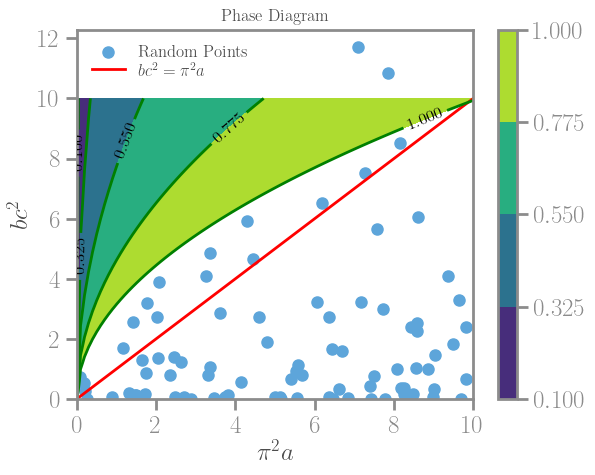

In [112]:
num_points = 100
points = [eig.book_of_the_numbers(scale_c=2, scale_b=3) for _ in range(num_points)]
x_values = [np.pi**2 * point["a"] for point in points]
y_values = [point["b"] * point["c"]**2 for point in points]

def compute_D(a, b, c):
    return (np.pi**2 * a / (b * c**2))**(1/3)

# Create a scatter plot
plt.scatter(x_values, y_values, label='Random Points')
plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')


# Plot contour lines of the function D
a_values = np.linspace(0, 10, 100)
bc2_values = np.linspace(0, 10, 100)
A, BC2 = np.meshgrid(a_values, bc2_values)
D_values = compute_D(A, 1, BC2)  # Assuming b = 1 for simplicity
contour_lines = plt.contour(A, BC2, D_values, levels=np.linspace(.1, 1, 5), colors='green')
contourf = plt.contourf(A, BC2, D_values, levels=np.linspace(.1, 1, 5))
cbar = plt.colorbar(contourf)

plt.xlabel(r'$\pi^2 a$')
plt.ylabel(r'$b c^2$')
# plt.ylim([-3, 50])
plt.title('Phase Diagram')
plt.legend()


# Add contour labels
contour_labels = plt.clabel(contour_lines, inline=True, fontsize=12, colors='black')

# Add annotations for iso-D values
# for i, txt in enumerate(contour_labels):
    # plt.annotate(f'D={np.around(D_values[0, i], decimals=2)}', (txt.get_position()[0], txt.get_position()[1]))


In [52]:
compute_D(1, 1, 1)

2.1450293971110255

# Phase computation parametric

In [19]:
import os
cwd = os.getcwd()
path_components = cwd.split(os.path.sep)
path_components = path_components[0:-2]
dirroot =  '/' + os.path.join(*path_components, 'test', 'output', 'rayleigh-benchmark-parametric', 'MPI-1')

!ls $dirroot


06808bac7882952b9370be6b2039164e 5c7ca577865c83a225bac7413e984243
2be9e4cfecb92dd64399235ecd6cda75 6f75e27fd2217e6ae3302506d471f903
3c05ab9a5a759a3adb73c98280aa0706 761d2f24d28b7be2b7be8e3c9283a3cc
4008f7309718b6c041d67e1df419da16 7fc954e6a16c9db01466a73d4ff4863e
46e496acc5cc6b84744165e5de0a837f cd51ebe88c87def741f0826374e1c256
5796fd374d76ec67e0b456dcfb26436d f181dd1f8b8b21a1c9b9f19461c9829f


In [63]:
successful_points = []
unsuccessful_points = []
data_for_plotting = []


for subdir, _, _ in os.walk(dirroot):
    parameters = load_parameters(subdir)
    signature = load_signature(subdir)
    if parameters is not None:
        a = parameters.get('model', {}).get('a')
        b = parameters.get('model', {}).get('b')
        c = parameters.get('model', {}).get('c')
    #     # Check if the computation is successful based on the existence of mode_shapes_data.npz
        success_file = os.path.join(subdir, 'mode_shapes_data.npz')
        if os.path.exists(success_file):
            successful_points.append((a, b*c**2))
            data = np.load(os.path.join(subdir, 'mode_shapes_data.npz'), allow_pickle=True)
            D_support = data['global_values'].item()['D_support']
            D_theory = data['global_values'].item()['D_theory']
            R_vector = data['global_values'].item()['R_vector']
            R_cone = data['global_values'].item()['R_cone']
            
            # Append data for plotting
            data_for_plotting.append({'pisq_a': np.pi**2*a, 'bc_squared': b*c**2, 'D_support': D_support, 'D_theory': D_theory, 
                                      'R_vector': R_vector, 'R_cone': R_cone, 'signature': signature})
            
        else:
            unsuccessful_points.append((a, b*c**2))
            data = []

In [64]:
successful_points, unsuccessful_points

([(0.022253728919148563, 0.005029409113574005),
  (0.40443655542659573, 0.0025757225917151442),
  (0.08480212277130916, 0.39234425699811387),
  (0.07000328054281169, 3.4391331719253095),
  (0.5226095869336886, 0.4967810610897649),
  (0.4788054142316467, 1.2340693667994287),
  (0.308576710138175, 1.1738008080820965),
  (0.9665326927229143, 2.526508487062358),
  (0.8828991748421459, 1.1209435836311639),
  (0.10275945788280538, 0.9246152972803707)],
 [(0.9991063748527327, 0.49517835799830756),
  (0.4924840719899225, 1.1385235993321767)])

In [21]:
D_theory_values = [point['D_theory'] for point in data_for_plotting]
D_support_values = [point['D_support'] for point in data_for_plotting]








  cbar.set_label('$D^\#$')

  plt.xlabel('$\pi^2a$')

  plt.title('Phase Diagram of the Cone, support size $D^\#$, and target $|D^\#-D^*|$')

  return (x / y)**(1/3)

  return (x / y)**(1/3)



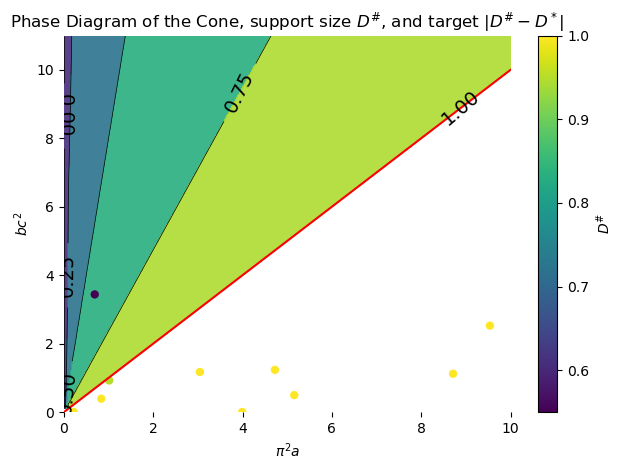

In [65]:
# Define the function
def func(x, y):
    return (x / y)**(1/3)

# Create a meshgrid
x = np.linspace(0, 10, 100)
y = np.linspace(0, 11, 100)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 1, 5), alpha=.9)

D_theory_values = [point['D_theory'] for point in data_for_plotting]
D_support_values = [point['D_support'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=D_support_values, cmap='viridis', edgecolors='black', linewidths=.0, label='Data')

# Add a colorbar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label('$D^\#$')
contour_lines = plt.contour(X, Y, Z, levels=np.linspace(0, 1, 5), colors='black', alpha=1, linestyles='solid', linewidths = .5)


# for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
#     if i % 5 == 0 and error !=0:  # Display error for every n-th point
#         plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom')

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

# manual_labels = {1.0: "$\pi^2 a = bc^2$"}  # Add labels for specific contour levels

contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='black',
                            inline_spacing=10)

# Customize the spines
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

# plt.xlim(0, 10)  # Replace with your desired limits
# plt.ylim(0, 10)  # Replace with your desired limits

# Set custom ticks
# plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
# plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.legend()
# Customize the plot
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Phase Diagram of the Cone, support size $D^\#$, and target $|D^\#-D^*|$')
# plt.show()
plt.tight_layout()
# plt.loglog()
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.pdf', dpi=300)
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.png', dpi=300)

In [66]:
[(point.get('signature'), np.abs(float((point['D_support']-point['D_theory'])))) for point in data_for_plotting]

[('4008f7309718b6c041d67e1df419da16', 0.0),
 ('5c7ca577865c83a225bac7413e984243', 0.0),
 ('5796fd374d76ec67e0b456dcfb26436d', 0.0),
 ('6f75e27fd2217e6ae3302506d471f903', 0.035674589273046786),
 ('06808bac7882952b9370be6b2039164e', 0.0),
 ('7fc954e6a16c9db01466a73d4ff4863e', 0.0),
 ('2be9e4cfecb92dd64399235ecd6cda75', 0.0),
 ('cd51ebe88c87def741f0826374e1c256', 0.0),
 ('46e496acc5cc6b84744165e5de0a837f', 0.0),
 ('761d2f24d28b7be2b7be8e3c9283a3cc', 0.050000000000000044)]









  cbar.set_label('$D^\#$')

  plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom')

  plt.xlabel('$\pi^2a$')

  plt.title('Phase Diagram of the Cone, support size $D^\#$, and target $|D^\#-D^*|$')

  return (x / y)**(1/3)

  return (x / y)**(1/3)



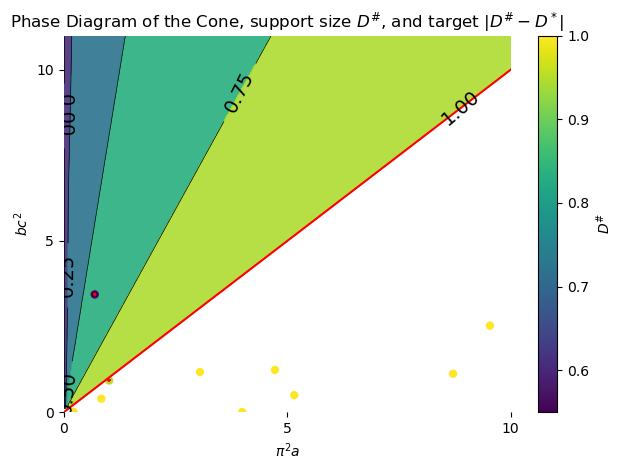

In [67]:
# Define the function
def func(x, y):
    return (x / y)**(1/3)

# Create a meshgrid
x = np.linspace(0, 10, 100)
y = np.linspace(0, 11, 100)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 1, 5), alpha=.9)

D_theory_values = [point['D_theory'] for point in data_for_plotting]
D_support_values = [point['D_support'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=D_support_values, cmap='viridis', edgecolors='black', linewidths=.0, label='Data')

error_values = [np.abs(float((point['D_support']-point['D_theory']))) for point in data_for_plotting]
plt.errorbar(x_values, y_values, xerr=np.abs(error_values), yerr=np.abs(error_values), fmt='none', ecolor='red', alpha=0.9)
# Add a colorbar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label('$D^\#$')
contour_lines = plt.contour(X, Y, Z, levels=np.linspace(0, 1, 5), colors='black', alpha=1, linestyles='solid', linewidths = .5)


for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
    if i % 5 == 0 and error !=0:  # Display error for every n-th point
        plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom')

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

# manual_labels = {1.0: "$\pi^2 a = bc^2$"}  # Add labels for specific contour levels

contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='black',
                            inline_spacing=10)
                            # fmt=lambda x: manual_labels.get(x, str(x)))

# Customize the spines
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

plt.xlim(0, 10)  # Replace with your desired limits
# plt.ylim(0, 10)  # Replace with your desired limits

# Set custom ticks
plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.legend()
# Customize the plot
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Phase Diagram of the Cone, support size $D^\#$, and target $|D^\#-D^*|$')
# plt.show()
plt.tight_layout()
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.pdf', dpi=300)
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram.png', dpi=300)









  cbar.set_label('$R^\#$')

  plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom', color='white')

  plt.xlabel('$\pi^2a$')

  plt.title('Minimal Eigenvalue in the Cone and target $|R^\#-R^*|/R^*$')



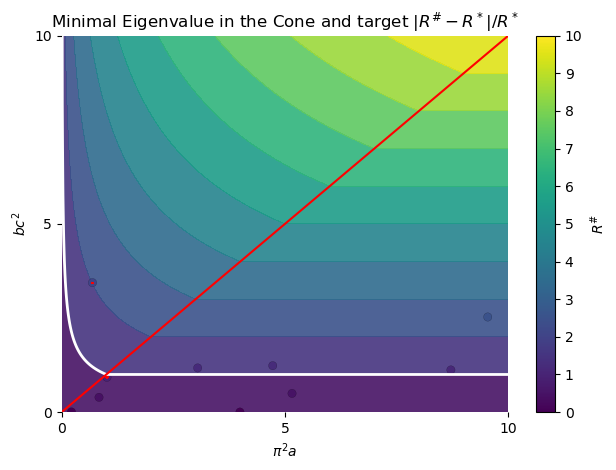

In [68]:
# Define the function
def func(x, y):
    # if y < x:
    #     return y
    # return (x)**(1/3)*(y)**(2/3)
    return np.where(y < x, y, x**(1/3) * y**(2/3))
    # return np.where(y < x, y, x)

# Create a meshgrid
x = np.linspace(0, 15, 1000)
y = np.linspace(0, 15, 1000)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
fig, ax = plt.subplots()

plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 10, 11), alpha=.9)

R_cone_values = [point['R_cone'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=R_cone_values, cmap='viridis', edgecolors='black', linewidths=.1, label='Data')

error_values = np.clip(np.abs([(point['R_cone'] - func(point['pisq_a'], point['bc_squared']).item())/func(point['pisq_a'], point['bc_squared']).item() 
                               for point in data_for_plotting]), 
                       0, 1)
# Add a colorbar to the plot
cbar = plt.colorbar(scatter, ticks=np.linspace(0, 10, 11))
scatter.colorbar.mappable.set_clim(0, 10)

cbar.set_label('$R^\#$')
contour_lines = plt.contour(X, Y, Z, levels=[1], colors='white', alpha=1, linestyles='solid', linewidths = 2)
contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='white',
                            inline_spacing=10, fmt=lambda x: f"$R=$ {x:.0f}")

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

plt.errorbar(x_values, y_values, yerr=error_values, xerr=error_values, fmt='none', ecolor='red', alpha=0.9)


for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
    if i % 10 == 0 and error > 1e-2:  # Display error for every n-th point
        plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom', color='white')

# Customize the plot
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

plt.xlim(0.0, 10)  # Replace with your desired limits
plt.ylim(0.0, 10)  # Replace with your desired limits


plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.gca().dist = 105
# plt.subplots_adjust(bottom=1)
# ax.margins(0.05)
# plt.legend()
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Minimal Eigenvalue in the Cone and target $|R^\#-R^*|/R^*$')
plt.tight_layout()

# plt.loglog()


# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_cone.pdf', dpi=300)
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_cone.png', dpi=300)









  cbar.set_label('$R^\#$')

  plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom', color='white')

  plt.xlabel('$\pi^2a$')

  plt.title('Minimal Eigenvalue in the Ball and target $|R^\#-R^*|/R^*$')



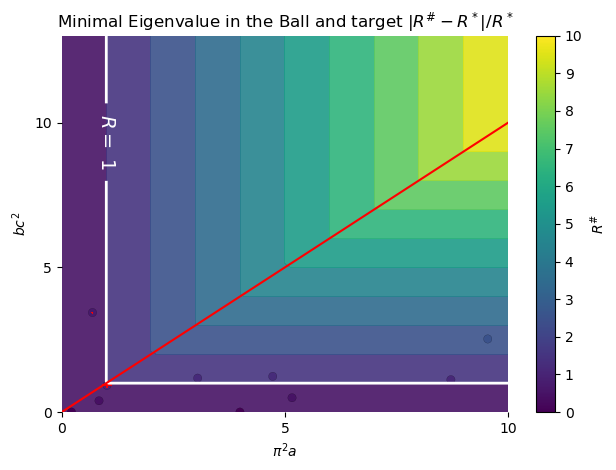

In [26]:
# Define the function
def func(x, y):
    return np.where(y < x, y, x)

# Create a meshgrid
x = np.linspace(0, 13, 100)
y = np.linspace(0, 13, 100)
X, Y = np.meshgrid(x, y)

# Calculate the function values on the meshgrid
Z = func(X, Y)
plt.contourf(X, Y, Z, cmap='viridis', levels=np.linspace(0, 10, 11), alpha=.9)

R_vector_values = [point['R_vector'] for point in data_for_plotting]

x_values, y_values = zip(*[(point['pisq_a'], point['bc_squared']) for point in data_for_plotting])

# Create a scatter plot and color the points based on D_theory
scatter = plt.scatter(x_values, y_values, c=R_vector_values, cmap='viridis', edgecolors='black', linewidths=.1, label='Data')

error_values = np.clip(np.abs([(point['R_vector'] - func(point['pisq_a'], point['bc_squared']).item())/func(point['pisq_a'], point['bc_squared']).item() for point in data_for_plotting]), 0, 3)
plt.errorbar(x_values, y_values, xerr=np.abs(error_values), yerr=np.abs(error_values), fmt='none', ecolor='red', alpha=0.9)
# Add a colorbar to the plot
cbar = plt.colorbar(scatter, ticks=np.linspace(0, 10, 11))
scatter.colorbar.mappable.set_clim(0, 10)

cbar.set_label('$R^\#$')
contour_lines = plt.contour(X, Y, Z, levels=[1], colors='white', alpha=1, linestyles='solid', linewidths = 2)

for i, (x, y, error) in enumerate(zip(x_values, y_values, error_values)):
    if i % 10 == 0 and error > 1e-3:  # Display error for every n-th point
        plt.text(x, y, f'{error*100:.0f}\%', fontsize=8, ha='left', va='bottom', color='white')

plt.plot(np.linspace(0, 10), np.linspace(0, 10), color='red', label=r'$bc^2 = \pi^2 a$')

# # manual_labels = {1.0: "$\pi^2 a = bc^2$"}  # Add labels for specific contour levels

contour_labels = plt.clabel(contour_lines, inline=True, fontsize=14, colors='white',
                            inline_spacing=10, fmt=lambda x: f"$R =$ {x:.0f}")
#                             # fmt=lambda x: manual_labels.get(x, str(x)))

# Customize the spines
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

plt.xlim(0, 10)  # Replace with your desired limits
# plt.ylim(0, 10)  # Replace with your desired limits

# Set custom ticks
plt.xticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions
plt.yticks(np.linspace(0, 10, 3))  # Replace with your desired tick positions

# plt.legend()
# Customize the plot
plt.xlabel('$\pi^2a$')
plt.ylabel('$bc^2$')
plt.title('Minimal Eigenvalue in the Ball and target $|R^\#-R^*|/R^*$')
# plt.show()
plt.tight_layout()
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_ball.pdf', dpi=300)
# plt.savefig('../../test/output/rayleigh-benchmark-parametric/phase_diagram_R_ball.png', dpi=300)

### Cherry pick the profile

In [34]:
dirroot = '../../test/output/rayleigh-benchmark-parametric/MPI-1'


In [35]:
os.path.join(dirroot, f'profile_comparison-{signature}.pdf')

'../../test/output/rayleigh-benchmark-parametric/MPI-1/profile_comparison-761d2f24d28b7be2b7be8e3c9283a3cc.pdf'

3c05ab9a5a759a3adb73c98280aa0706
4008f7309718b6c041d67e1df419da16
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
5c7ca577865c83a225bac7413e984243
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
5796fd374d76ec67e0b456dcfb26436d
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
6f75e27fd2217e6ae3302506d471f903
case 2
[{A, x}, {A, x}]
1.16627161259858*sqrt(A**2/pi**2 + 0.367595845599178*A**2) True False
depends_on_A
case 2
sqrt(0.136519012294621*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.136519012294621*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.546076049178484*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.136519012294621*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.273038024589242*pi**0.666666666666667)*sqrt(C**2)
depends_on_C
06808bac7882952b9370be6b2039164e
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C
case 1
sqrt(C**2)
depends_on_C
7fc954e6a16c9db

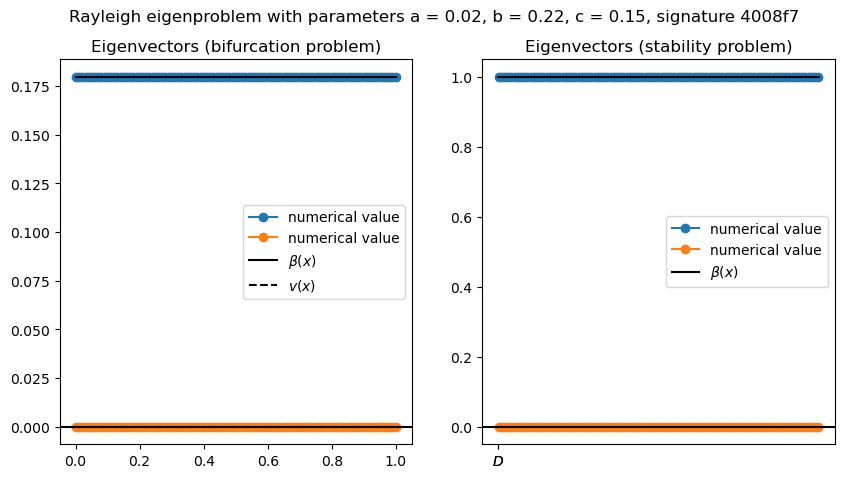

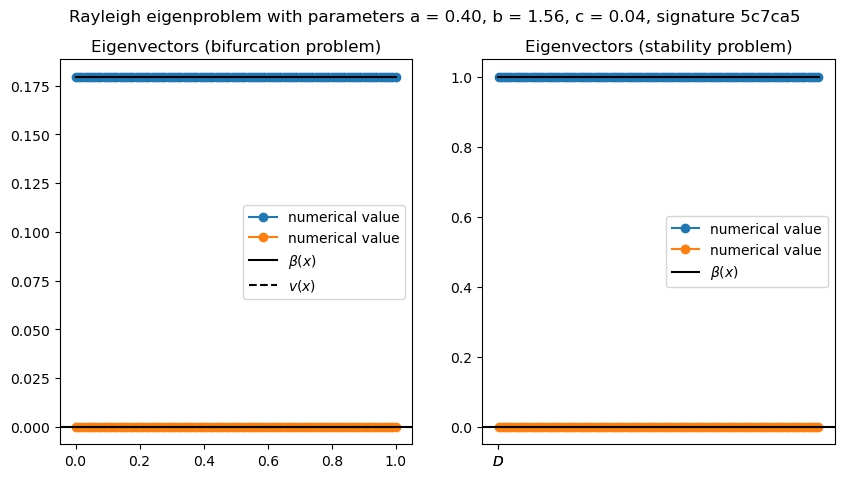

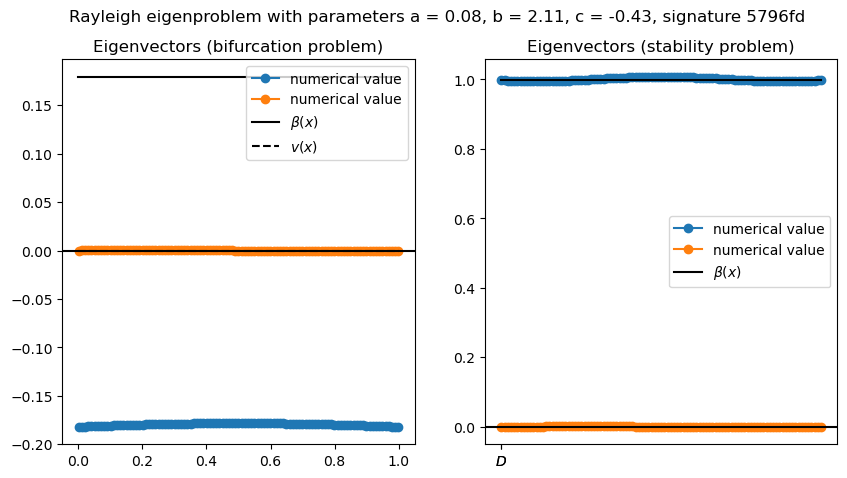

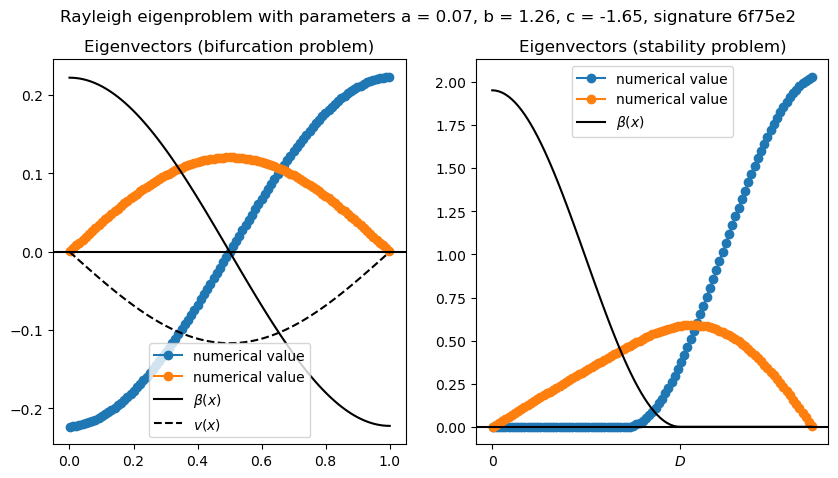

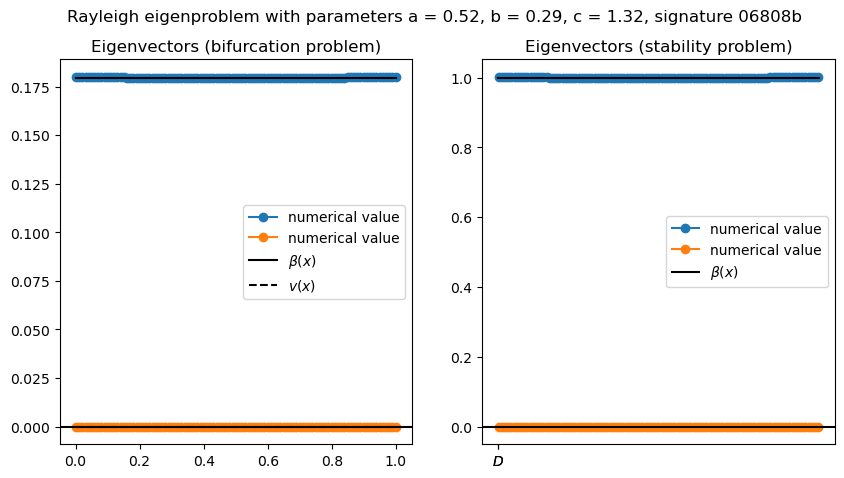

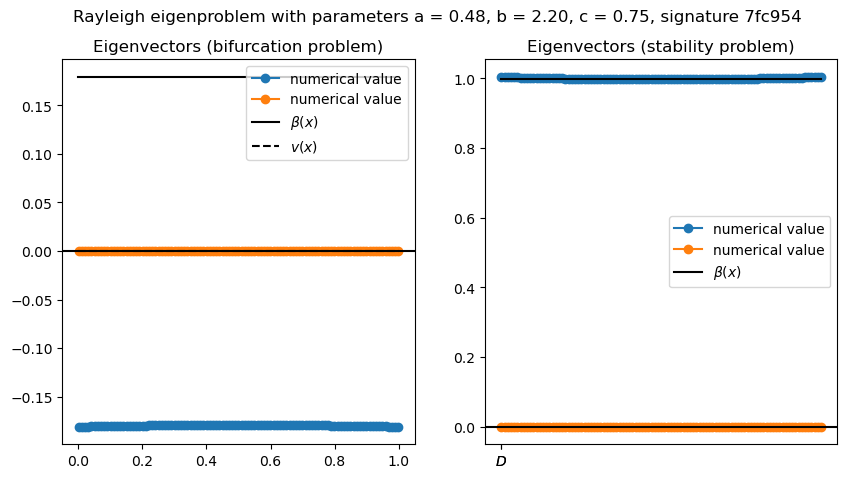

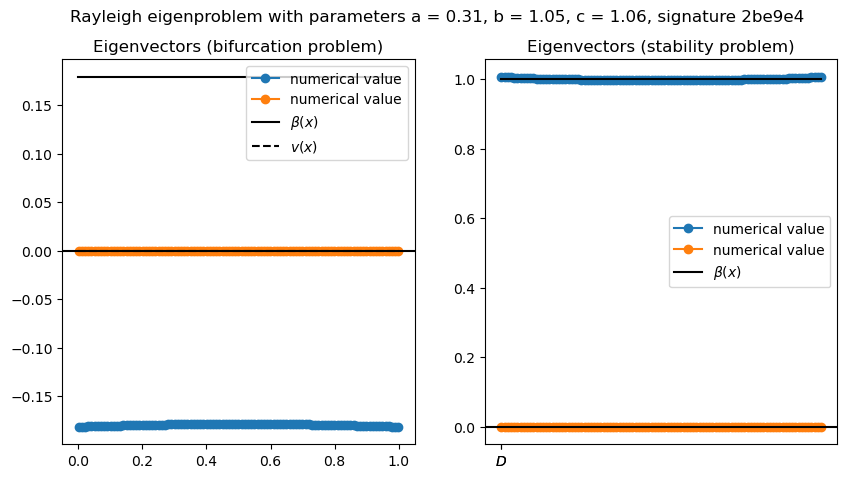

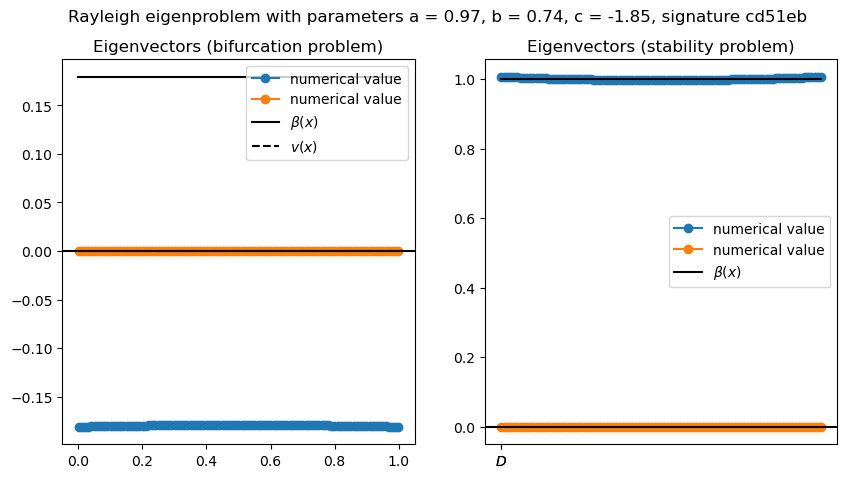

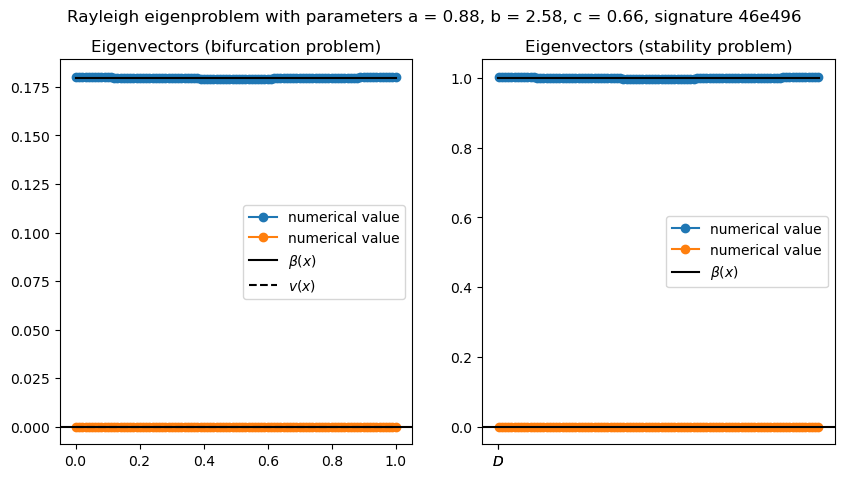

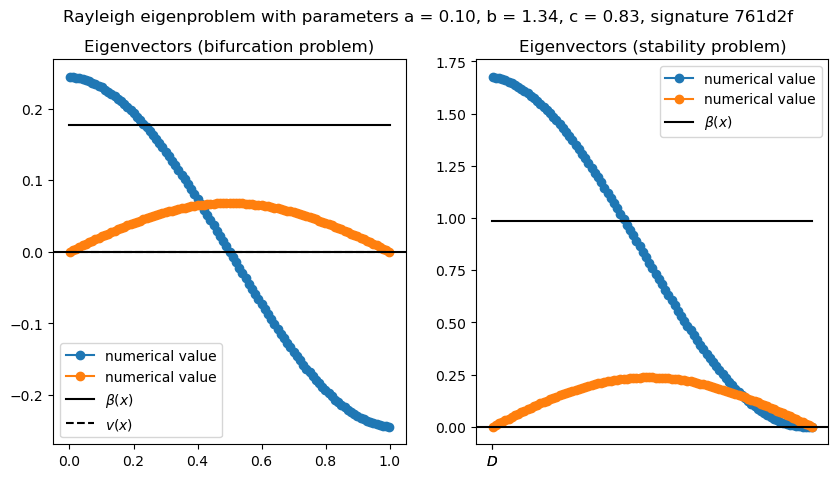

In [70]:
successful_points = []
unsuccessful_points = []
data_for_plotting = []


for subdir, _, _ in os.walk(dirroot):
    parameters = load_parameters(subdir)
    signature = load_signature(subdir)
    
    if signature is None:
        continue
    print(signature)

    if parameters is not None:
        a = parameters.get('model', {}).get('a')
        b = parameters.get('model', {}).get('b')
        c = parameters.get('model', {}).get('c')

        success_file = os.path.join(subdir, 'mode_shapes_data.npz')
        if os.path.exists(success_file):
            successful_points.append((a, b*c**2))
            modes_data = np.load(os.path.join(subdir, 'mode_shapes_data.npz'), allow_pickle=True)
            mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)
            
            parameters = {"a": a, "b": b, "c": c}
            fig, ax = plot_profile_comparison(parameters, mode, idx=[1, 0], reverse=False, signature=signature)
            # fig.savefig(os.path.join(subdir, 'profile_comparison.pdf'), dpi=300)
            # fig.savefig(os.path.join(dirroot, f'profile_comparison-{signature}.pdf'), dpi=300)
            # plt.close(fig)

In [41]:
!ls ../../test/output/rayleigh-benchmark-parametric/MPI-1

06808bac7882952b9370be6b2039164e 5c7ca577865c83a225bac7413e984243
2be9e4cfecb92dd64399235ecd6cda75 6f75e27fd2217e6ae3302506d471f903
3c05ab9a5a759a3adb73c98280aa0706 761d2f24d28b7be2b7be8e3c9283a3cc
4008f7309718b6c041d67e1df419da16 7fc954e6a16c9db01466a73d4ff4863e
46e496acc5cc6b84744165e5de0a837f cd51ebe88c87def741f0826374e1c256
5796fd374d76ec67e0b456dcfb26436d f181dd1f8b8b21a1c9b9f19461c9829f


File 'time_data.json' not found. Handle this case accordingly.
case 2
[{A, x}, {A, x}]
1.16627161259858*sqrt(A**2/pi**2 + 0.367595845599178*A**2) True False
depends_on_A
case 2
sqrt(0.136519012294621*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.136519012294621*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.546076049178484*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.136519012294621*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.273038024589242*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Eigenvectors (bifurcation problem)'}>,
        <Axes: title={'center': 'Eigenvectors (stability problem)'}>],
       dtype=object))

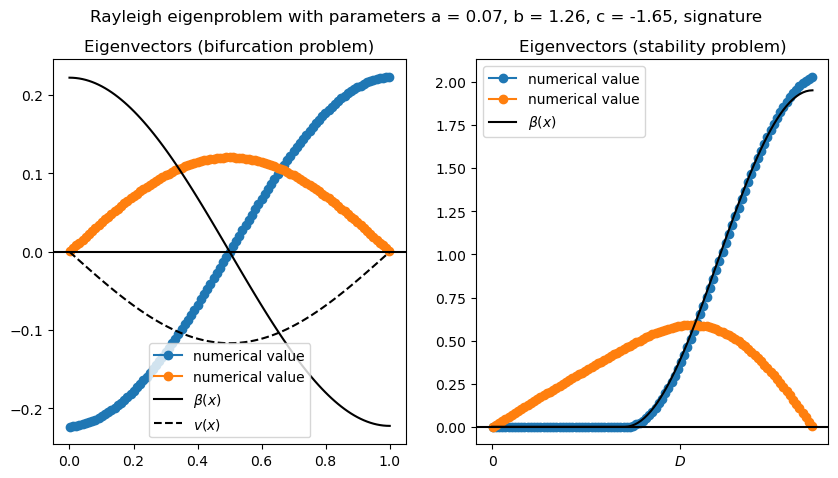

In [76]:
experiment = '../../test/output/rayleigh-benchmark-parametric/MPI-1/6f75e27fd2217e6ae3302506d471f903'

modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)

params, data, signature = pp.load_data(experiment)

a = params['model']['a']
b = params['model']['b']
c = params['model']['c']

parameters = {"a": a, "b": b, "c": c}

plot_profile_comparison(parameters, mode, idx=[1, 0], reverse=True)

# plt.savefig(os.path.join('../../test/output/rayleigh-benchmark/MPI-1', 'profile_comparison.pdf'), dpi=300)
# plt.savefig(os.path.join('../../test/output/rayleigh-benchmark/MPI-1', 'profile_comparison.png'), dpi=300)


